# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<!-- ![flower image](https://raw.githubusercontent.com/udacity/pytorch_challenge/master/assets/Flowers.png) -->
<img src='https://raw.githubusercontent.com/udacity/pytorch_challenge/master/assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [ ]:
import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets, transforms

In [ ]:
# Check if the cuda is availabel
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# running_on_google_colab = True


# if running_on_google_colab:
#     !wget https://raw.githubusercontent.com/udacity/pytorch_challenge/master/cat_to_name.json
#     !wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
#     !unzip flower_data.zip

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler


normalize_mean = np.array([0.485, 0.456, 0.406])
normalize_std = np.array([0.229, 0.224, 0.225])


# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomChoice([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(180)
        ]),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        normalize_mean, 
        normalize_std)
    ])



# Transforms validation dataset

valid_transforms = transforms.Compose([transforms.Resize(225),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(normalize_mean,
                                                           normalize_std)
                                      ])

# Data directory on kaggle

data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'


# choose the training and validation datasets
image_dataset_train_data = datasets.ImageFolder(train_dir, transform = train_transforms)
image_dataset_val_data = datasets.ImageFolder(valid_dir, transform = valid_transforms)

##### Splitting the data validation datasets:
> valid_dataset

> test_dataset

It will help for further evaluation for our model

In [ ]:
# obtain validation and test datasets that will be used to evaluate the network
num_valid = len(image_dataset_val_data)
indices = list(range(num_valid))
np.random.shuffle(indices)  
split = int(np.floor(num_valid * 0.5))
valid_idx, test_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
valid_sample = SubsetRandomSampler(valid_idx)
test_sample = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(image_dataset_train_data, batch_size = 32, 
                                           shuffle = True, num_workers = 0)
valid_loader = torch.utils.data.DataLoader(image_dataset_val_data, batch_size = 20, 
                                           shuffle = False, sampler = valid_sample, num_workers = 0)
test_loader = torch.utils.data.DataLoader(image_dataset_val_data, batch_size = 20, 
                                          shuffle = False, sampler = test_sample, num_workers = 0)


# Printing and know batching size
print("Training data : {} images / {} batches".format(len(image_dataset_train_data), len(train_loader)))
print("Validation data: {} images / {} batches".format(len(valid_loader.sampler), len(valid_loader)))
print("Test data: {} images / {} batches".format(len(test_loader.sampler), len(test_loader)))

Training data : 6559 images / 205 batches
Validation data: 409 images / 21 batches
Test data: 409 images / 21 batches


#### Label Mapping:
You'll also need to load in a mapping from category label to category name. You can find this in the file cat_to_name.json. It's a JSON object which you can read in with the json [module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [ ]:
import json

In [ ]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# This is very important function while using imageFolder; 
# Its mapping appropritate labels data to the folder
class_to_idx = image_dataset_train_data.class_to_idx


cat_label_to_name = {}
for cat, label in class_to_idx.items():
    name = cat_to_name.get(cat)  # Return a values by .get function in the dict.
    cat_label_to_name[label] = name  # mapping apt key, value pair

print(cat_label_to_name)

{0: 'pink primrose', 1: 'globe thistle', 2: 'blanket flower', 3: 'trumpet creeper', 4: 'blackberry lily', 5: 'snapdragon', 6: "colt's foot", 7: 'king protea', 8: 'spear thistle', 9: 'yellow iris', 10: 'globe-flower', 11: 'purple coneflower', 12: 'peruvian lily', 13: 'balloon flower', 14: 'hard-leaved pocket orchid', 15: 'giant white arum lily', 16: 'fire lily', 17: 'pincushion flower', 18: 'fritillary', 19: 'red ginger', 20: 'grape hyacinth', 21: 'corn poppy', 22: 'prince of wales feathers', 23: 'stemless gentian', 24: 'artichoke', 25: 'canterbury bells', 26: 'sweet william', 27: 'carnation', 28: 'garden phlox', 29: 'love in the mist', 30: 'mexican aster', 31: 'alpine sea holly', 32: 'ruby-lipped cattleya', 33: 'cape flower', 34: 'great masterwort', 35: 'siam tulip', 36: 'sweet pea', 37: 'lenten rose', 38: 'barbeton daisy', 39: 'daffodil', 40: 'sword lily', 41: 'poinsettia', 42: 'bolero deep blue', 43: 'wallflower', 44: 'marigold', 45: 'buttercup', 46: 'oxeye daisy', 47: 'english marig

### Visualize a Batch of Training Data

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


def imgView(img, title, ax):
    for i in range(img.shape[0]):
        img[i] = img[i] * normalize_std[i] + normalize_mean[i]
        img[i] = img[i]
        
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(title)

    

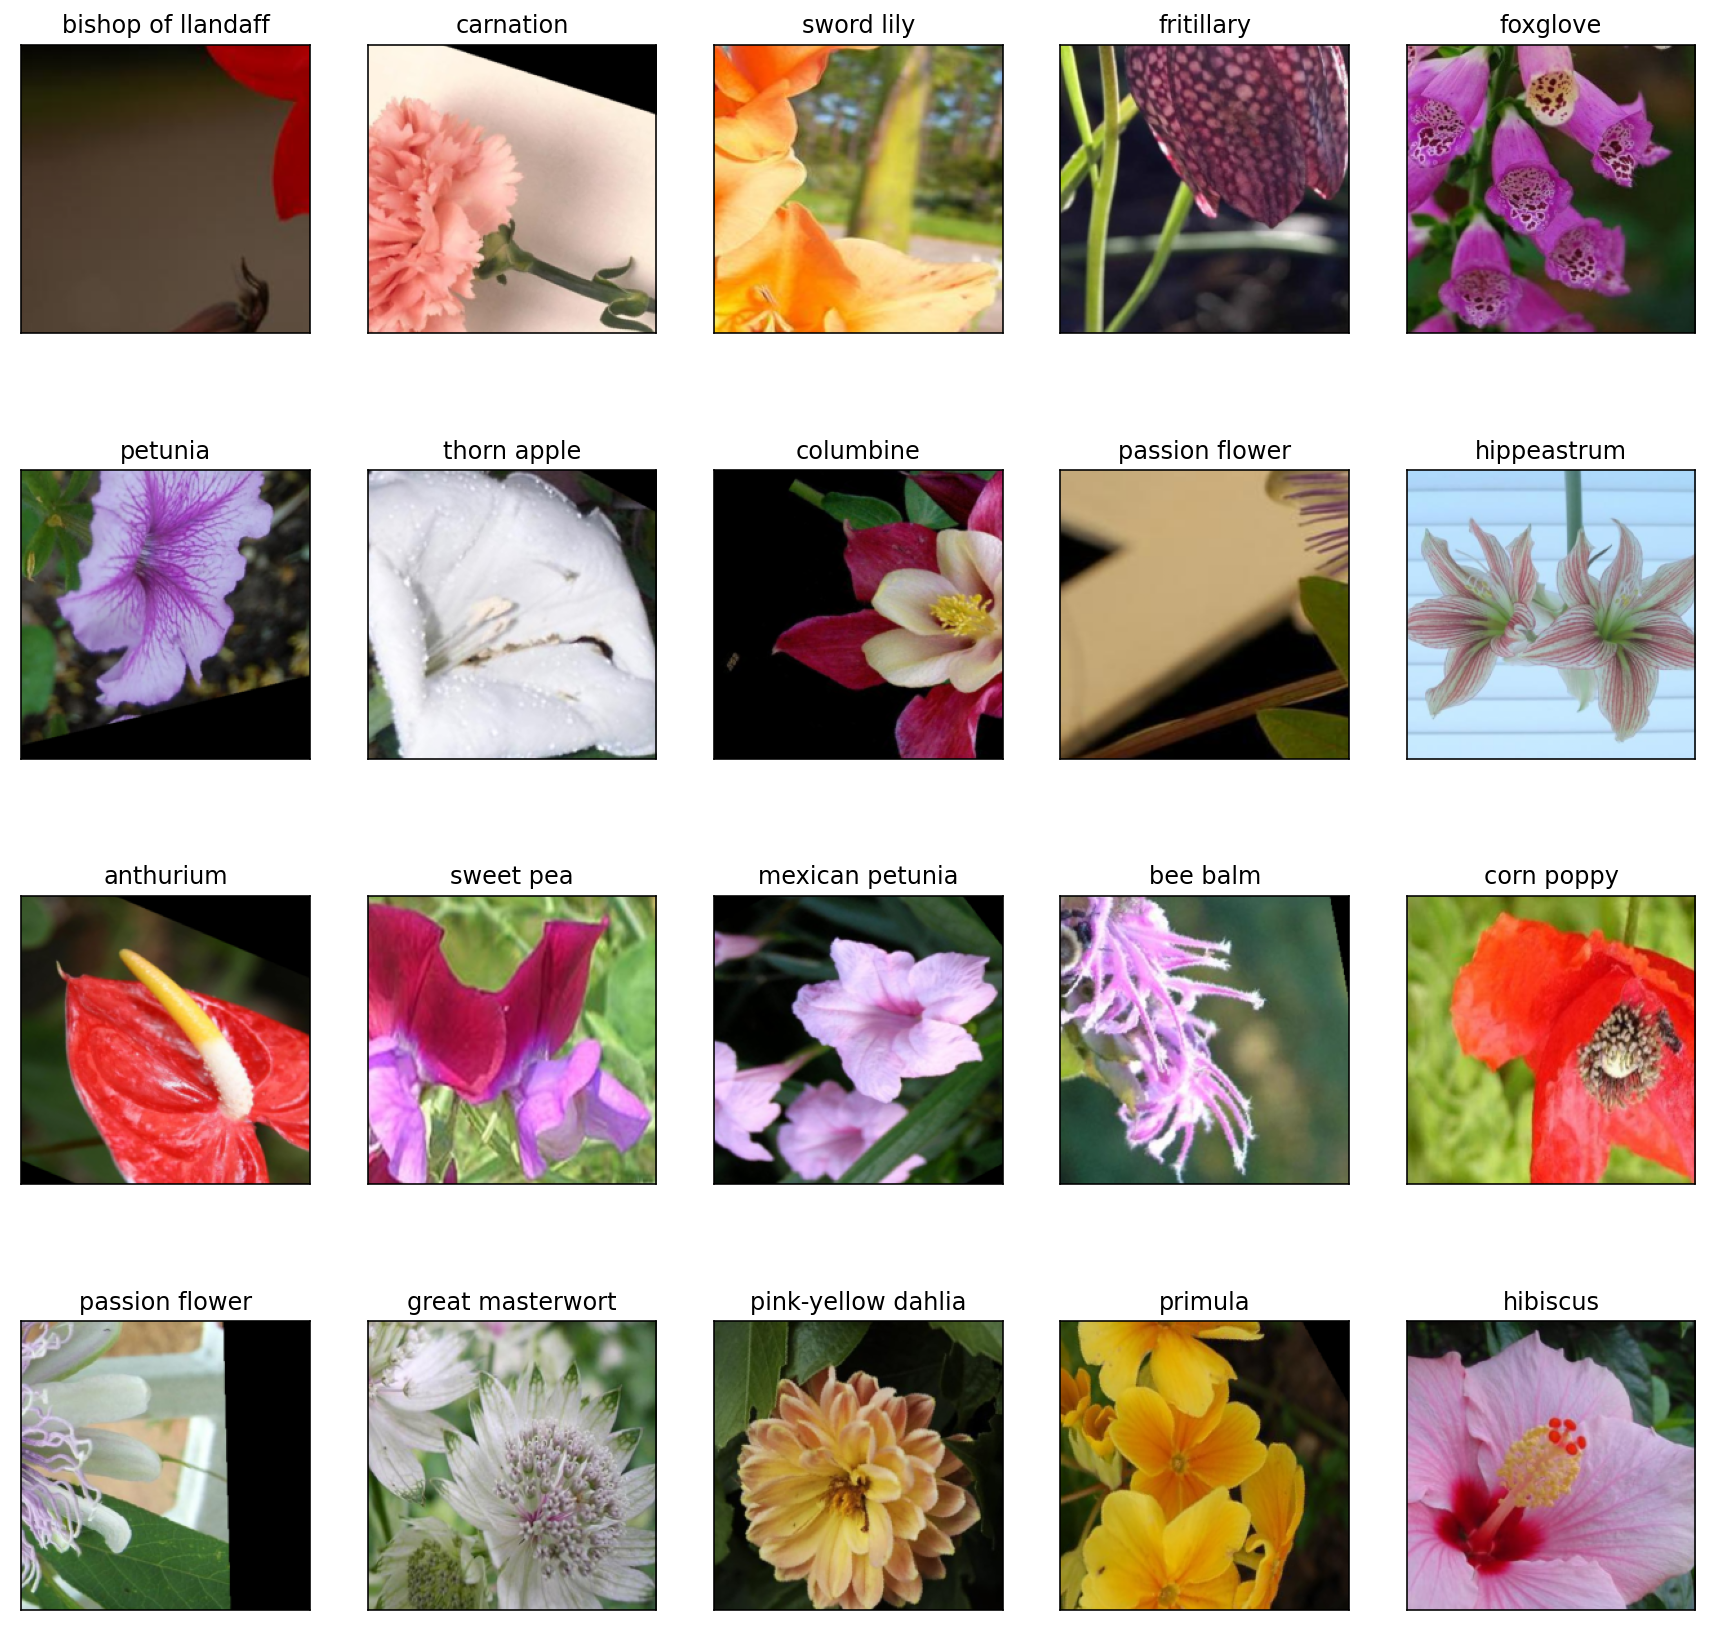

In [ ]:
images, labels = next(iter(train_loader))
images = images.numpy()  # Convert tensor to numpy

fig = plt.figure(figsize = (15, 15))
rows, cols = 4, 5

for idx in np.arange(rows * cols):
    img = images[idx]
    label = labels[idx].item()
    title = cat_label_to_name[label]
    ax = fig.add_subplot(rows, cols, idx+1, xticks=[], yticks=[])
    
    imgView(img, title, ax)
    

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [ ]:
# TODO: Use a pretrained model to classify the Oxford flower classification
# Use GPU if its available
train_on_gpu = torch.cuda.is_available()


In [ ]:
# pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 121 kB 20.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 73.6 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 52.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from torchvision import models

# Initialize the resenet50
model = models.resnet50(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
# Neural network architecture
    
from collections import OrderedDict
F_classifer = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 1048)),
                                        ('relu', nn.ReLU()),
                                        ('dropout', nn.Dropout(p=0.3)),
                                        ('fc2', nn.Linear(1048, 102)),
                                        ('LogSoftMax', nn.LogSoftmax(dim=1))]))

model.fc = F_classifer

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# Define the loss function
criterion = nn.NLLLoss()

# Intialize Optimizer
optimizer = optim.Adam(model.fc.parameters(), lr = 0.001)

# Define scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min')

# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma = 0.1)

# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones = [20, 40, 60], gamma = 0.1)

# Shifting if you've GPU 
if train_on_gpu:
    model.cuda()

In [ ]:
print(len(valid_loader))
print(len(train_loader))

21
205


In [ ]:
train_losses = []
valid_losses = []
accuracy = []

In [ ]:
def train(model, epochs = 1, train_loader = train_loader, valid_loader = valid_loader, optimizer = optimizer, graph = False):

    import time

    epochs_end = 80

    valid_loss_min = np.Inf  # Track the changes in the validation losses

    elapsed_time = 0

    for e in range(epochs, epochs_end + epochs):

        train_loss = 0

        ###################
        # train the model #
        ###################
        start = time.time()

        # Tranning the model
        model.train()
        for images, labels in train_loader:

            # Shifting the computation on GPU if available otherwise on CPU
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()

            # Set to the zero grad
            optimizer.zero_grad()

            # Pass data to the network
            output = model(images)
            loss = criterion(output, labels)

            # Use backprop
            loss.backward()

            # Set the weight by calling the optimizer
            optimizer.step()

            train_loss += loss.item() * len(images)  ## 32 in batches

        end = time.time()

        elapsed_time += end - start

        ###################
        # Validation #
        ###################
        valid_loss = 0
        valid_accuracy = 0

        # Shut down dropout layer
        model.eval()

        # No gradient calculation
        with torch.no_grad():

            for images, labels in valid_loader:

                if train_on_gpu:   
                    images, labels = images.cuda(), labels.cuda()

                output = model(images)

                # Calculate loss for this validation batch
                loss = criterion(output, labels)
                # Track validation loss
                valid_loss += loss.item()*len(images)  # 20 len of img in first batch

                # Calculate accuracy
                ps = torch.exp(output)
                top_ps, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                valid_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*len(images)


        # Measures the loss of each epoch
        train_loss = train_loss/len(image_dataset_train_data)
        valid_loss = valid_loss/len(valid_loader.sampler)
        valid_accuracy = valid_accuracy/len(valid_loader.sampler)
        
        # Update learning rate
        scheduler.step(valid_loss)
        #scheduler.step()
        
       #################
        # Save Model #
       ################
        
        '''Save Model'''
        # Create the checkpoint with relevent information  
        if valid_loss <= valid_loss_min:
            
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                 valid_loss_min, valid_loss))
            
            checkpoint_info = {
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                            }
            torch.save(checkpoint_info, 'classifier.pt')
            valid_loss_min = valid_loss
                
            
        
        # Appending losses into the list for analysis
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        accuracy.append(valid_accuracy)
                

       ################
        # Print log #
       ################

        # print training/validation statistics 
        print('Epoch: {}'.format(e),
              '\tLr: {:.6f}'.format(optimizer.state_dict()['param_groups'][0]['lr']),
              '\tTraining loss: {:.6f}'.format(train_loss),
              '\tValidation loss: {:.6f}'.format(valid_loss), 
              '\tValidation accracy: {:.2f}%'.format(valid_accuracy * 100),
              '\tElapsed time: {:.2f}'.format(elapsed_time))


       ################
        # Graph #
       ################
        
    if graph:

        plt.figure(figsize=(15, 6))
        plt.subplot(121)
        plt.plot(train_losses, 'orange', label = 'train_loss')
        plt.plot(valid_losses, 'red', label = 'valid_loss')
        plt.xlabel("Epochs");
        plt.ylabel("Losses");
        plt.legend();
        plt.title('Tranning and Validation losses')
        # plt.show()

        plt.subplot(122)
        plt.plot(accuracy, 'green', label = 'accuracy')
        plt.xlabel('Epochs')
        plt.legend();
        plt.title('Validation Accuracy');
        plt.show()

    
    

In [ ]:
def test(test_loader = test_loader, statistics=True):
    
    test_losses = 0
    test_loss = 0
    accuracy = 0
    test_accuracy = 0
    class_total = [0]*102  # total labels we have 102
    class_correct = [0]*102
    
    criterion = nn.NLLLoss()
    model.eval()
    
    with torch.no_grad():
        for images, labels in test_loader:
            
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()
                
            output = model(images)
            
            loss = criterion(output, labels)
            
            test_loss += loss.item()*len(images)
            
            # Calculate test accuracy
            ps = torch.exp(output)
            top_ps, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.sum(equals.type(torch.FloatTensor)).item() 
            
            for idx, lbl in enumerate(labels):
                class_total[lbl.item()] += 1
                class_correct[lbl.item()] += equals[idx].item()
            
    # Measure the loss
    test_losses = test_loss/len(test_loader.sampler)
    test_accuracy = accuracy/len(test_loader.sampler)

        
    ################
     # Print log #
    ################
    print('Test loss: {:.6f}'.format(test_losses), 
          '\tTest score: {}/{}'.format(int(accuracy), len(test_loader.sampler)),
          '\tTest accuracy: {:.2f}%'.format(test_accuracy * 100))
    
    if statistics:
        print('Accuracy per class: ')
        for idx, num in enumerate(class_total):
            clss = image_dataset_train_data.classes[idx]
            name = cat_to_name.get(clss)
            accuracy = class_correct[idx]
            accuracy_rate = accuracy / num if num !=0 else 0
            
            print('\t{:<4} \t{:<50} \t{}/{:<3} \t{:<5}%'.format(clss, name, accuracy, num, accuracy_rate * 100))
            

Validation loss decreased (inf --> 1.561583).  Saving model ...
Epoch: 1 	Lr: 0.001000 	Training loss: 3.282263 	Validation loss: 1.561583 	Validation accracy: 62.84% 	Elapsed time: 102.00
Validation loss decreased (1.561583 --> 0.864918).  Saving model ...
Epoch: 2 	Lr: 0.001000 	Training loss: 1.623197 	Validation loss: 0.864918 	Validation accracy: 77.75% 	Elapsed time: 204.04
Validation loss decreased (0.864918 --> 0.627874).  Saving model ...
Epoch: 3 	Lr: 0.001000 	Training loss: 1.254557 	Validation loss: 0.627874 	Validation accracy: 85.09% 	Elapsed time: 306.36
Validation loss decreased (0.627874 --> 0.605419).  Saving model ...
Epoch: 4 	Lr: 0.001000 	Training loss: 1.081447 	Validation loss: 0.605419 	Validation accracy: 85.33% 	Elapsed time: 408.89
Validation loss decreased (0.605419 --> 0.551350).  Saving model ...
Epoch: 5 	Lr: 0.001000 	Training loss: 0.987124 	Validation loss: 0.551350 	Validation accracy: 85.57% 	Elapsed time: 513.86
Validation loss decreased (0.551350

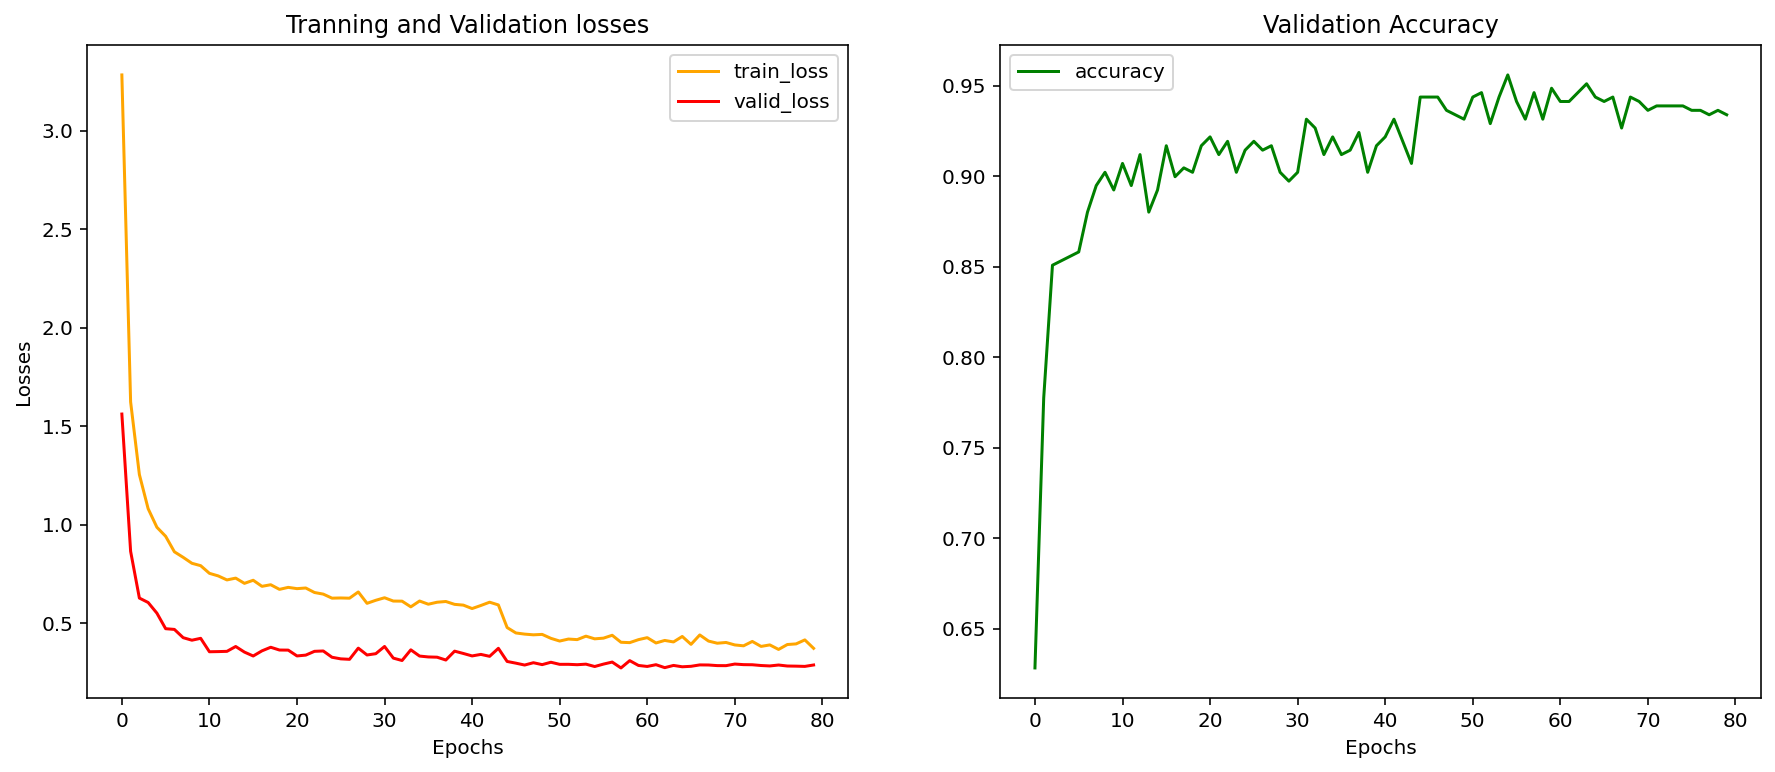

In [ ]:
train(model, graph=True)

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [ ]:
# Save the checkpoint 
# def save_checkpoint(checkpoint_path='checkpoint.pt'):
#     model.to('cpu')
#     checkpoint = {'model_name': model_name,
#                   'output_size': output_size,
#                   'hidden_layers': hidden_layers,
#                   'model_state_dict': model.state_dict(),
#                   'class_to_idx': class_to_idx,
#                   'cat_label_to_name': cat_label_to_name}

#     torch.save(checkpoint, checkpoint_path)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [ ]:
# Load the model

PATH = './classifier.pt'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
test(statistics=True)

Test loss: 0.148924 	Test score: 389/409 	Test accuracy: 95.11%
Accuracy per class: 
	1    	pink primrose                                      	5/5   	100.0%
	10   	globe thistle                                      	3/3   	100.0%
	100  	blanket flower                                     	5/5   	100.0%
	101  	trumpet creeper                                    	3/3   	100.0%
	102  	blackberry lily                                    	3/3   	100.0%
	11   	snapdragon                                         	5/6   	83.33333333333334%
	12   	colt's foot                                        	4/4   	100.0%
	13   	king protea                                        	4/4   	100.0%
	14   	spear thistle                                      	0/0   	0    %
	15   	yellow iris                                        	3/3   	100.0%
	16   	globe-flower                                       	1/1   	100.0%
	17   	purple coneflower                                  	7/7   	100.0%
	18   	peruvian lily       

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

## Helper function define for inferences

In [ ]:
import torchvision.transforms.functional as TF

In [ ]:
def process_image(image):
    """
    Input: Image
    output: return normalize images as size 256, center crop image by 224 pixes
    """
    images = TF.resize(image, 256)
    crop_top = (image.height - 224) // 2
    crop_left = (image.width - 224) // 2
    image = TF.crop(image, crop_top, crop_left, 224, 224)
    
    image = TF.to_tensor(image)
    image = TF.normalize(image, normalize_mean, normalize_std)
    
    return image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your **`process_image`** function works, running the output through this function should return the original image (except for the cropped out portions).

In [ ]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1);

    ax.imshow(image);
    ax.axis('off');
    
    if title:
        ax.set_title(title, fontsize = 13);

    return ax

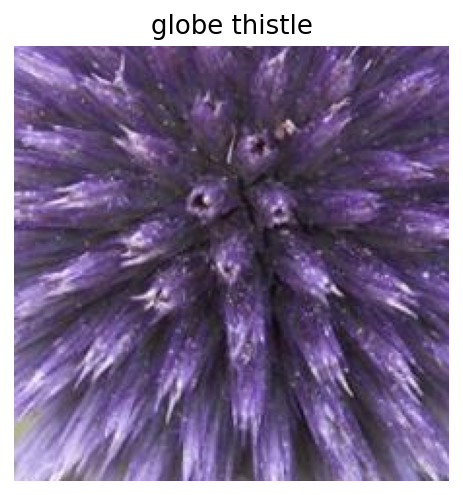

In [ ]:
from PIL import Image
category = 10
image_name = 'image_07086.jpg'
# image_path = 'flower_data/train/74/image_01147.jpg'

img_path =  'flower_data/train/'+ str(category) + '/' + str(image_name)
image = Image.open(img_path)
image = process_image(image)
imshow(image, title = cat_to_name[str(category)]);

## Class Prediction
Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the `top 5` or so **(usually called top- K)** most probable classes. You'll want to calculate the class probabilities then find the **K** largest values. 

To get the top **K** largest values in a tensor use `x.topk(k)`. This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using **`class_to_idx`** which hopefully you added to the model or from an **ImageFolder** you used to load the data (see here). Make sure to invert the dictionary so you get a mapping from index to class as well.

In [ ]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # TODO: Implement the code to predict the class from an image file
    image = Image.open(image_path)
    tensor_image = process_image(image)
    
    model.to('cpu')
    tensor_image.to('cpu')
    
    model.eval()
    
    log_ps = model.forward(tensor_image.unsqueeze(0))
    ps = torch.exp(log_ps)
    probs, classes = ps.topk(topk, dim=1)
    probs, classes = probs.detach().numpy()[0], classes.detach().numpy()[0]
    
    return probs, classes, tensor_image

In [ ]:
probs, classes, tensor_image = predict(img_path, model) 

In [ ]:
# print('Probability: {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(probs[0], probs[1], probs[2], probs[3], probs[4]))
print(probs)
print(classes)
names = [cat_label_to_name[idx] for idx in classes]
print(names)

[9.7227442e-01 1.3845742e-02 1.1551975e-02 1.8346013e-03 1.4209896e-04]
[ 1 26 34 31 28]
['globe thistle', 'sweet william', 'great masterwort', 'alpine sea holly', 'garden phlox']


In [ ]:
# We are taking img_path
def display_result(image_path, model, category, cat_label_to_name = cat_label_to_name):
    
    probs, classes, tensor_image = predict(image_path, model) 
    print('Proability: ', probs)
    print('Classes of flower: ', classes)
    
    names = [cat_label_to_name[idx] for idx in classes]
    print('Names of the classes: ', names)

    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(8,4))

    # For figure 1
    imshow(tensor_image, ax = ax1, title = cat_to_name[str(category)]);

    # For figure 2
    ax2.barh(names, probs);
    ax2.set_title("Class Probability");
    ax2.set_xlim(0, 0.50)
    ax2.set_aspect(0.1)
    plt.tight_layout()
    plt.gca().invert_yaxis()


Proability:  [0.97772825 0.01102809 0.00549155 0.00311382 0.00174826]
Classes of flower:  [ 0 49 84 87 13]
Names of the classes:  ['pink primrose', 'petunia', 'hibiscus', 'tree mallow', 'balloon flower']


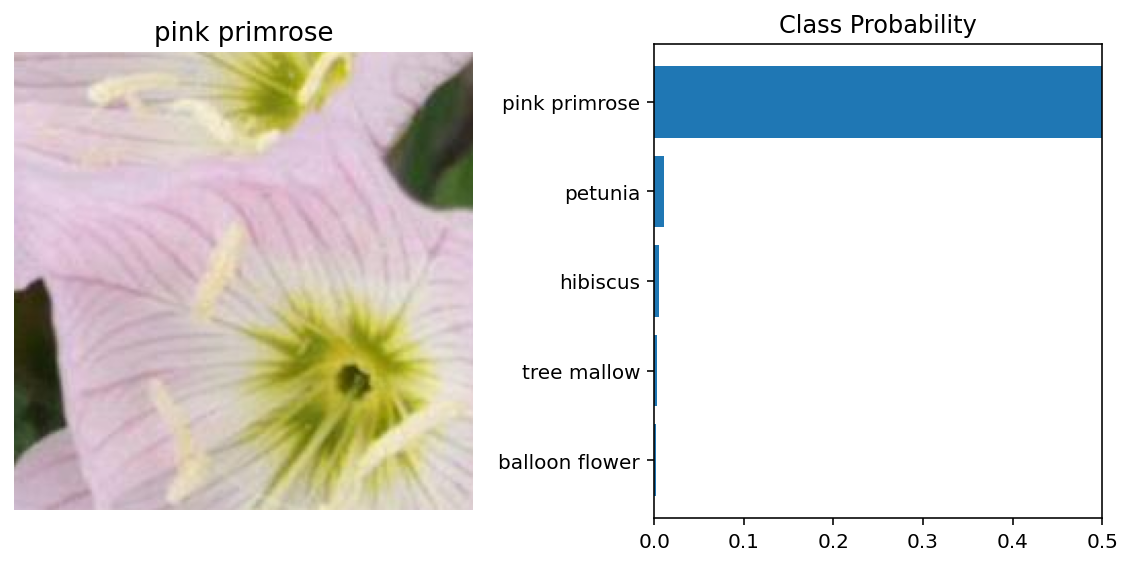

In [ ]:
display_result('flower_data/train/1/image_06744.jpg', model, category=1)

Proability:  [9.9999964e-01 2.9289762e-07 2.0537966e-08 3.9977888e-09 3.1163447e-09]
Classes of flower:  [ 4 58 92 18 79]
Names of the classes:  ['blackberry lily', 'tiger lily', 'canna lily', 'fritillary', 'toad lily']


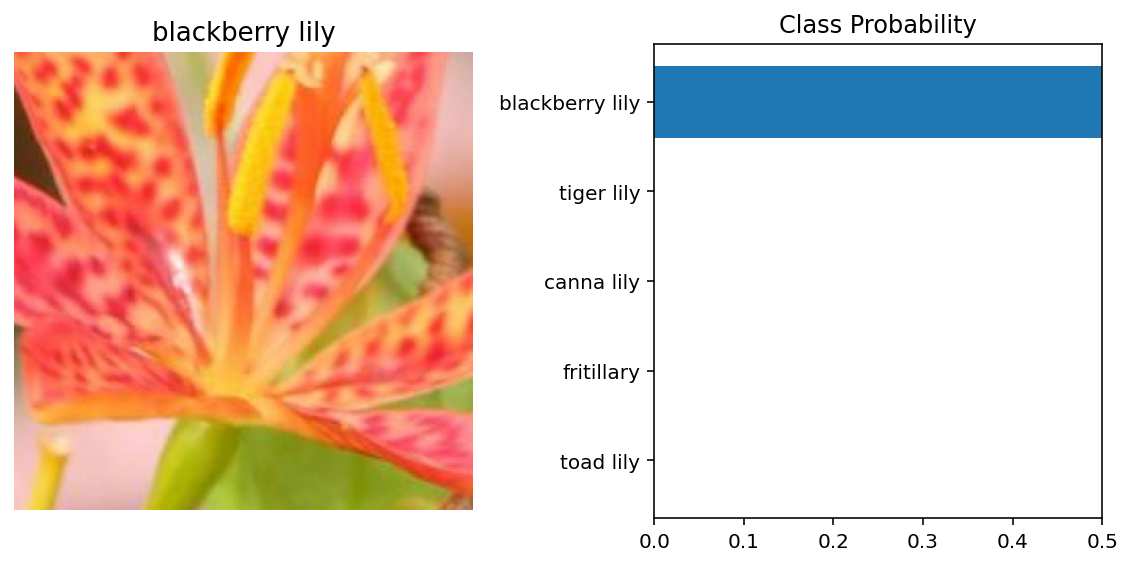

In [ ]:
display_result('flower_data/train/102/image_08007.jpg', model, category=102)

## Visualize the Sample Test Result

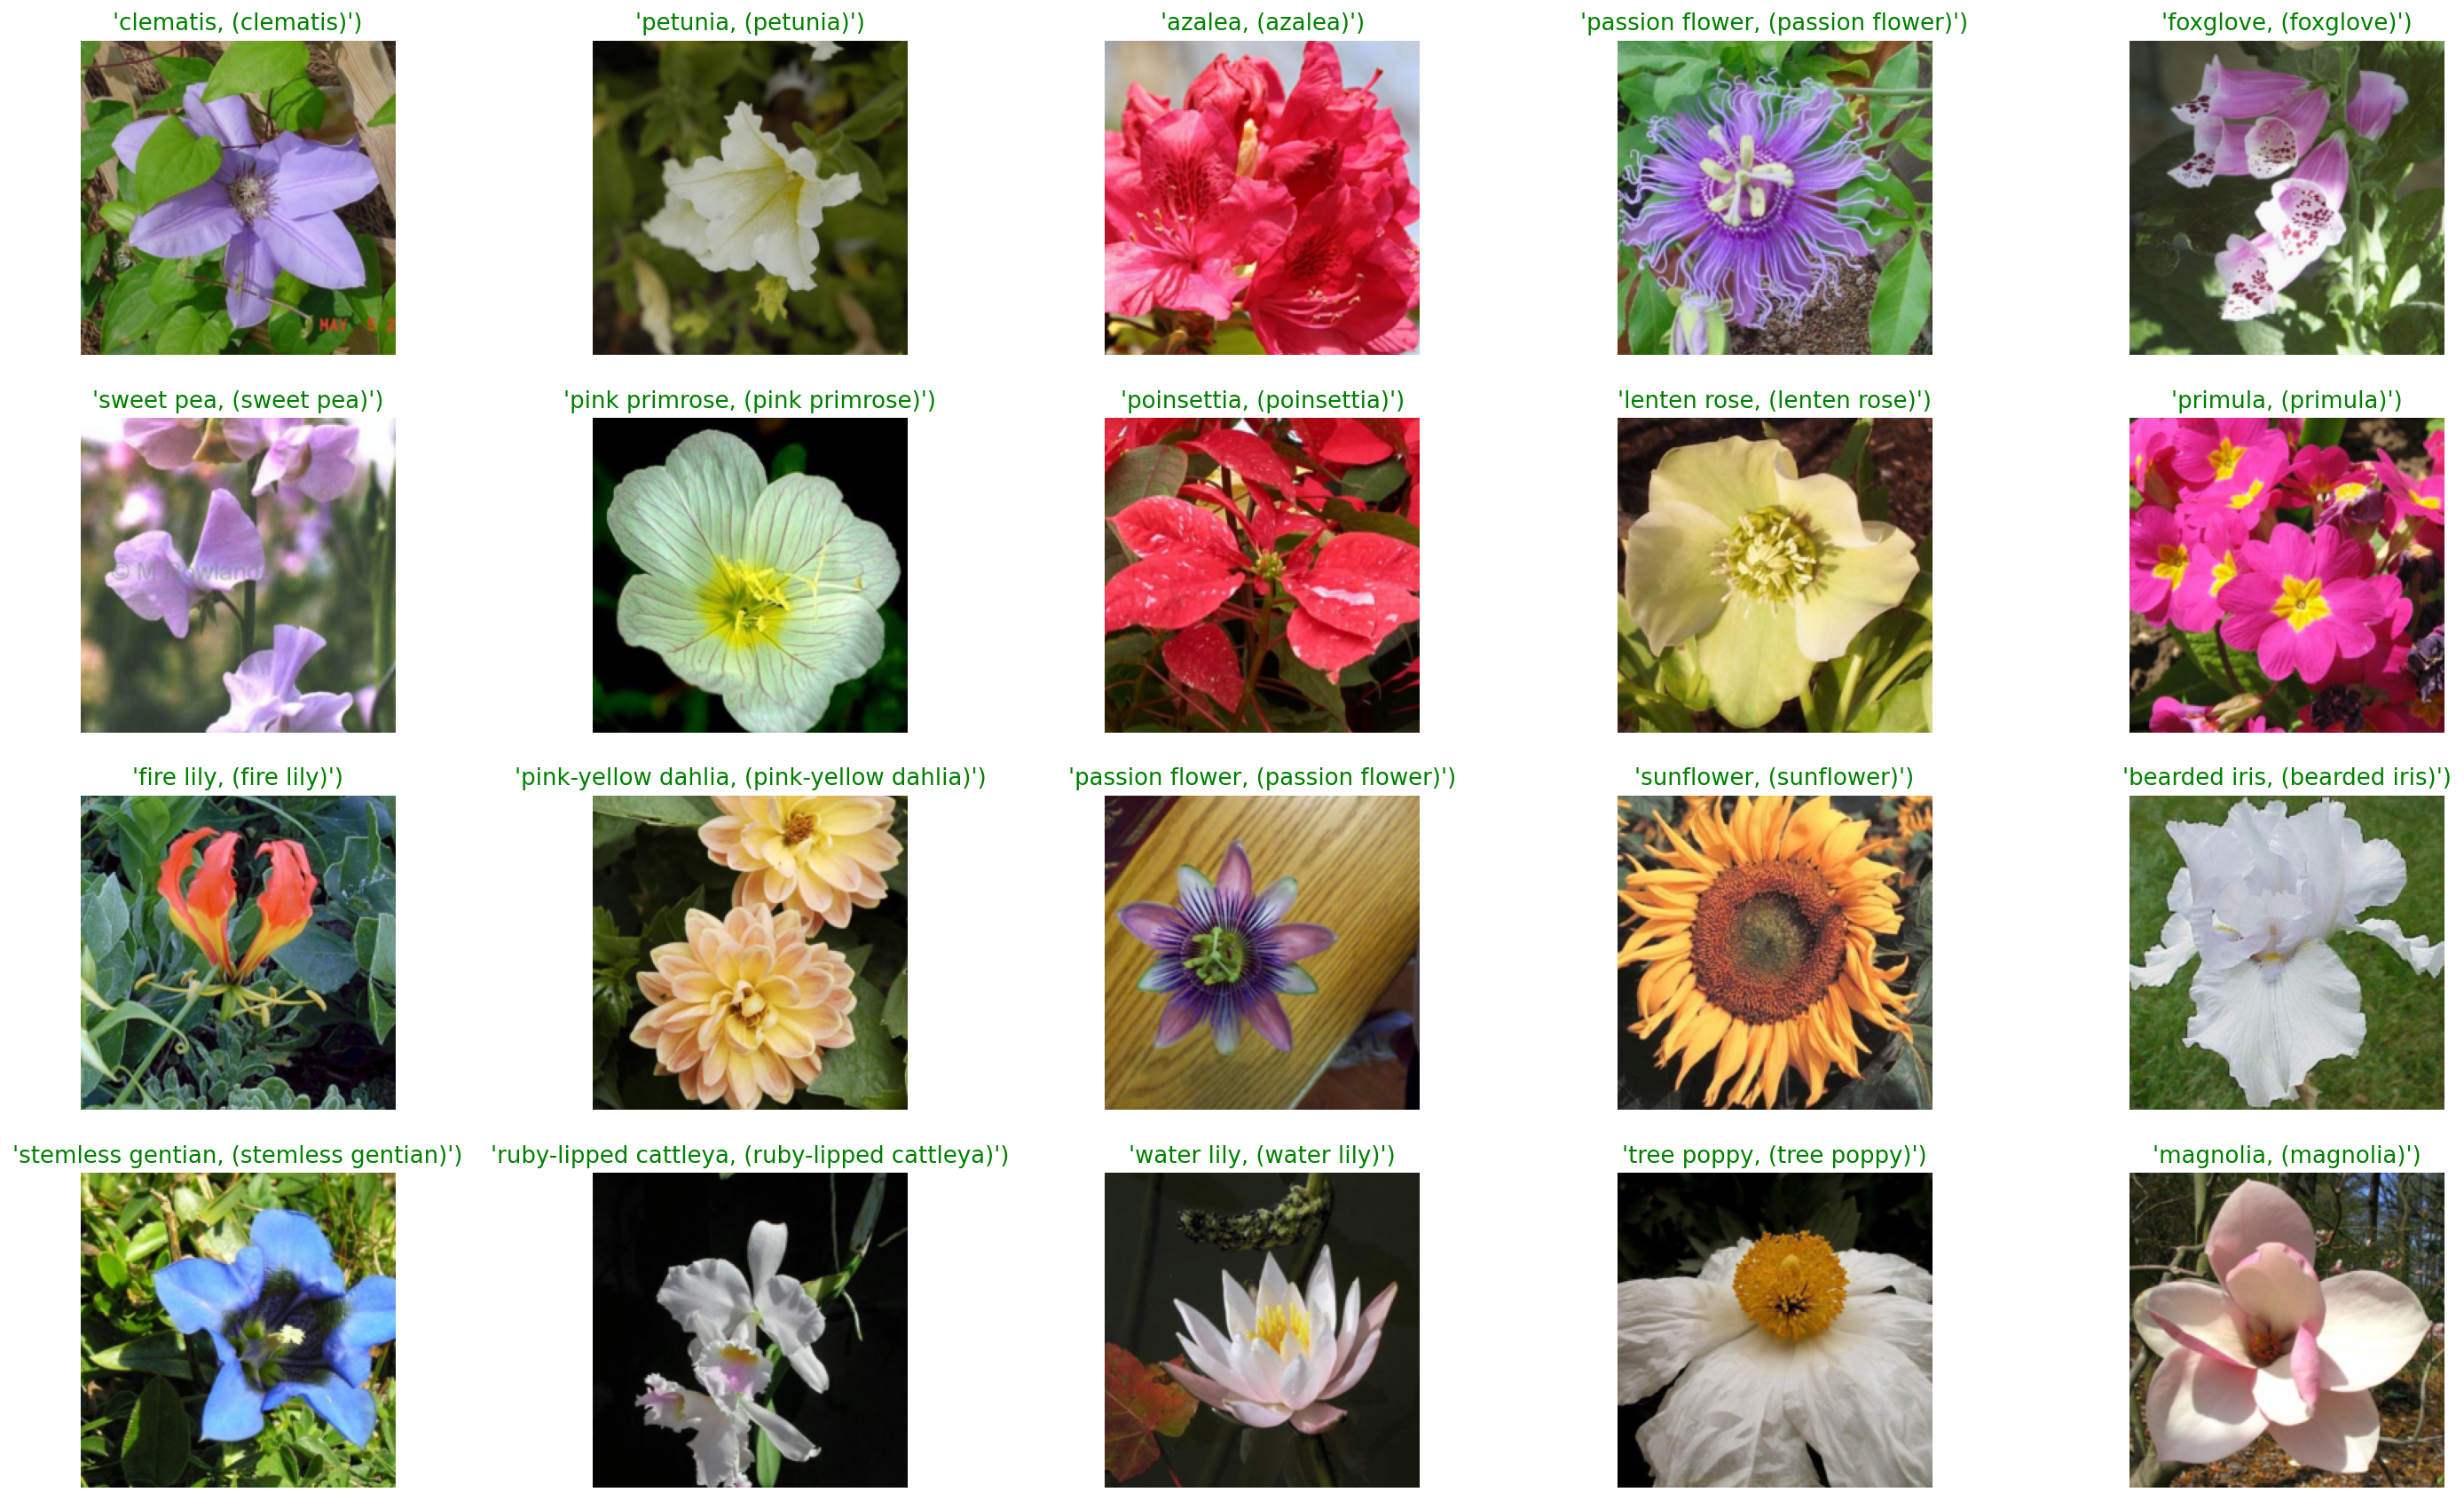

In [ ]:
# Obtain one batch of test imgae
images, labels = next(iter(test_loader))

images.numpy()
labels = labels.numpy()

# Move to the GPU, if its available
    
# Get the output
output = model(images)

probablity, classes = torch.max(output, 1)

preds = np.squeeze(classes.numpy()) if not train_on_gpu else np.squeeze(classes.cpu().numpy())

# print(type(preds), preds)
# print(type(labels), labels)
# Plot the image with batch along with prdicted labeles and original labels

fig = plt.figure(figsize=(25, 15))
for idx in np.arange(20):
    ax1 = fig.add_subplot(4, int(20/4), int(idx+1), xticks=[], yticks = [])
    
    title = ax1.set_title("{}, ({})".format(cat_label_to_name[preds[idx]], cat_label_to_name[labels[idx]]),
                         color = ("green" if preds[idx] == labels[idx].item() else "red"));
    
    title = str(title).replace('Text(0.5, 1.0, ', '')  # Removing the unwanted text

    imshow(images[idx] if not train_on_gpu else images[idx].cpu(), ax=ax1, title= title) 

#     print(cat_label_to_name[preds[idx]], cat_label_to_name[labels[idx]])